<a href="https://colab.research.google.com/github/HrithikNambiar/Out-of-Distribution-Detection-for-Skin-Lesion-Classification/blob/main/VOS_Midsem_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Out-of-Distribution Detection for Skin Lesion Classification**

 

> **Vishwa Shah (2018A7TS0109G) | Hrithik Nambiar (2019A7PS0100G)  | Preeyam Sahu (2018A7PS0191G)**










Drive Link : https://drive.google.com/drive/folders/1nZUlpC8nQXk9Q-6YqGVRXKO9-EbbEpwh?usp=sharing 

All Datasets used in the submission are present in the above drive link.

Out-of-distribution (OOD) detection has received much attention lately due to its
importance in the safe deployment of neural networks. One of the key challenges
is that models lack supervision signals from unknown data, and as a result, can
produce overconfident predictions on OOD data. 

VOS (Virtual
Outlier Synthesis) is a novel framework that detects OOD examples by adaptively synthesizing
virtual outliers that can meaningfully regularize the model’s decision boundary during training.
Specifically, VOS samples virtual outliers from the low-likelihood region of the class conditional
distribution estimated in the feature space. It also introduces a novel unknown-aware training
objective, which contrastively shapes the uncertainty space between the In-Distribution data
and synthesized outlier data. 

In this work, we study the problems dealing with OOD data
for skin cancer classification and compare the performance of VOS with other State-of-the-art
methods.

In this notebook, you will find:


1.   State-of-the-art models such as VGG, Densenet, Resnet has been defined. We choose the best performing model (i.e. Densenet) on the HAM 10000 Dataset to classify skin images into the prominent types of skin cancer. We Analyse the classification results in detail.
2.   We show how this classification model fails on OOD datasets such as Clinical Skin, Derm skin, NCT and Imagenet. This serves as the inspiration for building OOD Detection models such as VOS. [Please go through the report shared for a detailed description of the datasets].
3. Answers to Task 1 and Task 2.

Next Steps:



1.   Test the performance of VOS for OOD detection and check if it out-performs the SOTA models in this task as reported in "On Out-of-Distribution Detection Algorithms with Deep Neural Skin Cancer
Classifiers" [1], CVPR 20' paper.
2. Detailed comparitive study of the performance on all 6 OOD datasets.


[1] On Out-of-Distribution Detection Algorithms with Deep Neural Skin Cancer
Classifiers (https://openaccess.thecvf.com/content_CVPRW_2020/papers/w42/Pacheco_On_Out-of-Distribution_Detection_Algorithms_With_Deep_Neural_Skin_Cancer_Classifiers_CVPRW_2020_paper.pdf)



Any OOD Detection task aims at testing if the model has received data-instances outside its distribution. For example, a model trained to detect MNIST digits will still give overconfident predictions on images from CIFAR-10. Along with performing the task on in-distribution data, we also want the model to be able to classify out-of-distribution data from distinct categories
 
* In-Distribution Data: For our in-distribution data we use HAM10000 which categorizes major categories of dermatoscopic lesions. We explain this dataset characteristics in detail in the later sections.
  * Training Data - 90% 
  * Validation Data - 10%
* Out-Of-Distribution Data: Our ultimate-task is to find instances from varying distributions. We use images from various categories and especially those tasks whose distributions are very similar to in-distribution data, making it difficult for the model to detect out-of-distribution


**TASK 1: Relevance of the Datasets chosen -** 

In our experiments, we consider seven skin lesions in the HAM 10000 dataset as the in-distribution set. For out-of-distributions, we create a collection of six datasets of varying complexity, designed to holistically evaluate out-of-distribution detection algorithms for skin cancer classification.
 
The selected datasets are- 
* Derm Skin: This dataset simulates dermoscopy images of healthy skins. This is obtained by cropping small patches from the ISIC 2019 dataset and selecting those ones that do not contain parts of the lesion. This set contains 1565 images.
* Clin skin - The same idea previously described is used to build a data-set of clinical images of healthy skin. This set contains 512 images collected from social networks.
* BBOX  - This dataset is obtained by corrupting the ISIC images by covering the lesion’s silhouette with a
black bounding box. This set contains 2025 images.
* BBOX 70 - This is the same idea as B-box; however, in this dataset, the bounding box covers at least 70% of the lesion. This set contains 2,454 images.
* NCT: This is a set of 1,350 histology images of human colorectal cancer (CRC) randomly selected (150 from each label) from the NCT-CRC-HE-7K dataset.
* Imagenet : We will randomly sample 1000 images from imagenet.
 
Let us understand the relevance of these datasets. Consider the current SOTA classification model trained on the HAM 10000 dataset which has seen 7 types of skin cancer during training. When this model is tested on an image of healthy skin whilst the model is being deployed, it classifies the healthy skin (Clin-Skin dataset) as a particular type of cancer with high confidence. Such, errors in the medical domain are not acceptable. 

Hence, it is important that the model detects the healthy skin to be “Out-Of-Distribution” and VOS is one such promising method for OOD detection which delivers SOTA results on a multitude of datasets.


# Importing necessary libraries

In [ ]:
#IMPORTS
# general libraries
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import random

# libraries for image processing
from PIL import Image
import cv2

# torch libraries
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models,transforms
from torch.autograd import Variable
import torch.nn.functional as F

# libraries for evaluating Image Classification performance
# and for creating train,test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# setting seed across libraries for reproducible results
random.seed(13)
np.random.seed(13)
torch.manual_seed(13)
torch.cuda.manual_seed(13)

## Loading HAM10000 : In-Distribution Data

HAM10000 is a collection of 10,015 images classifying dermatoscopic collection of pigmented skin lesions into 8 classes: 

Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

> Actinic keratoses and intraepithelial carcinoma / Bowen's disease (**akiec**),
 basal cell carcinoma (**bcc**), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, **bkl**), dermatofibroma (**df**), melanoma (**mel**), melanocytic nevi (**nv**) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, **vasc**).



[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018)

In [ ]:
# NECESSARY STEP
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NECESSARY STEP
# Please use the link mentioned in the start of the notebook, You can add the shortcut to the drive and run these commands
# Traverse to the directory which contains the VOS directory
%cd /content/drive/MyDrive/VOS

/content/drive/.shortcut-targets-by-id/1nZUlpC8nQXk9Q-6YqGVRXKO9-EbbEpwh/VOS


The necessary files and folders under the HAM10000 folder are:

*   HAM10000_images_part_1
*   HAM10000_images_part_2
*   HAM10000_metadata.csv

The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata.csv file.
(The image files are divided under part_1 and part_2)

The other files in the HAM10000 folder contains downsampled image data in greyscale or RGB form, but we use the original data to capture complete information

In [ ]:
ls

bbox_temp1000.npy      Datasets.gdoc           HAM_densenet_runv_5.pt
bbox_temp100.npy       data.zip                HAM_densenet_runv_6.pt
bbox_temp1.npy         HAM1000/                HAM_densenet_runv_7.pt
clin_ski_temp1000.npy  HAM1000ipynb            HAM_densenet_runv_8.pt
clin_ski_temp100.npy   HAM_densenet.pt         HAM_densenet_runv_final.pt
clin_ski_temp1.npy     HAM_densenet_runv_1.pt  OOD_detection.ipynb
CRC-VAL-HE-7K/         HAM_densenet_runv_2.pt  Submission.ipynb
CRC-VAL-HE-7K.zip      HAM_densenet_runv_3.pt  validation_dl.csv
data/                  HAM_densenet_runv_4.pt  VOS_Midsem.ipynb


In [ ]:
# to obtain all the image files within folders the directory of HAM10000
data_dir = "/content/drive/MyDrive/VOS/HAM1000"
images_path = glob(os.path.join(data_dir, '*', '*.jpg'))

# As the metadata uses image id, we need a mapping from image id to relative/abs file path
image_to_path = {os.path.splitext(os.path.basename(x))[0]: x for x in images_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Following is the mapping for cancer cell type code and the cell type 
* 'nv': 'Melanocytic nevi'
* 'mel': 'Melanoma'
* 'bkl': 'Benign keratosis-like lesions '
* 'bcc': 'Basal cell carcinoma'
* 'akiec': 'Actinic keratoses'
* 'vasc': 'Vascular lesions'
* 'df': 'Dermatofibroma'

In [ ]:
df_ham = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
# ['dx'] column contains the cancer cell type code
# We need to convert this into categorical variable for it to work on the model

df_ham['path'] = df_ham['image_id'].map(image_to_path.get)
df_ham['dx_type'] = df_ham['dx'].map(lesion_type_dict.get)
df_ham['dx_category'] = pd.Categorical(df_ham['dx_type']).codes
df_ham.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,dx_category
0,HAM_0000118,ISIC_0027419,bkl,Benign keratosis-like lesions,80.0,male,scalp,/content/drive/MyDrive/VOS/HAM1000/HAM10000_im...,2
1,HAM_0000118,ISIC_0025030,bkl,Benign keratosis-like lesions,80.0,male,scalp,/content/drive/MyDrive/VOS/HAM1000/HAM10000_im...,2
2,HAM_0002730,ISIC_0026769,bkl,Benign keratosis-like lesions,80.0,male,scalp,/content/drive/MyDrive/VOS/HAM1000/HAM10000_im...,2
3,HAM_0002730,ISIC_0025661,bkl,Benign keratosis-like lesions,80.0,male,scalp,/content/drive/MyDrive/VOS/HAM1000/HAM10000_im...,2
4,HAM_0001466,ISIC_0031633,bkl,Benign keratosis-like lesions,75.0,male,ear,/content/drive/MyDrive/VOS/HAM1000/HAM10000_im...,2


In [ ]:
mapping = dict( zip( df_ham['dx_category'], df_ham['dx_type'] ) ) #mapping category name to label

print("Label to Category")
mapping

Label to Category


{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Vascular lesions'}

In [ ]:
# Creating Train and Validation Split

# The dataset has certain lesions for which multiple images are present
# For an unbiased evaluation: for an lesion in validation set, its other images should not be present in the train set

# To find the occurrences of lesion_ids which have only one occurrence
df_lesion_cnt = df_ham.groupby('lesion_id').count()
df_uniq_lesion = df_lesion_cnt[df_lesion_cnt['image_id'] == 1]

df_uniq_lesion.reset_index(inplace=True)
uniq_lesion_id = df_uniq_lesion['lesion_id'].tolist()

print("Number of unique lesion ids : {}".format(len(uniq_lesion_id)))

Number of unique lesion ids : 5514


In [ ]:
# We choose our val from rows with the lesion_ids
uniq_lesion_idx = []

for i in range(df_ham.shape[0]):
  id = df_ham.iloc[i]['lesion_id']
  if id in uniq_lesion_id:
    uniq_lesion_idx.append(i)

# We use 10% of the total data as validation_set
n_val = int(0.1*df_ham.shape[0])
print(n_val)

1001


In [ ]:
# indexes chosen for val
random.seed(13) # this resets the sample space as random.sample works without replacement removing the earlier samples once it is called
val_idx = random.sample(uniq_lesion_idx, n_val)

# rest indices become part of the train data
train_idx = list(set(np.arange(df_ham.shape[0])) - set(val_idx))
print("Train size:{} Test size:{}".format(len(train_idx),len(val_idx)))

Train size:9014 Test size:1001


In [ ]:
df_train = df_ham[df_ham.index.isin(train_idx)]
df_val = df_ham[df_ham.index.isin(val_idx)]

In [ ]:
print(df_train['dx_category'].value_counts())
print(df_train['dx'].value_counts())

4    5912
5    1072
2    1005
1     484
0     307
6     130
3     104
Name: dx_category, dtype: int64
nv       5912
mel      1072
bkl      1005
bcc       484
akiec     307
vasc      130
df        104
Name: dx, dtype: int64


In [ ]:
print(df_val['dx_category'].value_counts())
print(df_val['dx'].value_counts())

4    793
2     94
5     41
1     30
0     20
6     12
3     11
Name: dx_category, dtype: int64
nv       793
bkl       94
mel       41
bcc       30
akiec     20
vasc      12
df        11
Name: dx, dtype: int64


**Limitations of HAM 10000** : As seen in the above distribution, there is a serious class imbalance in the HAM 10000. This is one of the major limitations of the dataset.

In [ ]:
# To mitigate the class imbalance, we copy less frequent classes multiple times to meet the class with highest frequency
# We copy multiple times using a scale value such that the class ends up being balanced. Note, this upsampling method is 
# a very common approach to deal with class imbalance.

freq = df_train['dx_category'].value_counts()
max_class = max(freq)

for i in range(len(freq)):
    scale = int((max_class - freq[i])/freq[i])
    if scale > 0:
      df_train = df_train.append([df_train.loc[df_train['dx_category']==i,:]]*scale, ignore_index=True)

# After scaling the imbalanced classes
print(df_train['dx_category'].value_counts())
print("Training Samples: {}".format(df_train.shape[0]))

4    5912
6    5850
0    5833
3    5824
1    5808
5    5360
2    5025
Name: dx_category, dtype: int64
Training Samples: 39612


In [ ]:
# To make the map style data loader work
df_train = df_train.reset_index()
df_val = df_val.reset_index()

Deep Learning models, especially those constituting CNNs have shown substantial improvements for detecting skin cancers from images. 

To use CNNs, we need to extract the image data from our current metadata

In [ ]:
# Creating a map-type dataloader

# For this we use the Dataset class provided by PyTorch
# This needs an implementation of __init__, __len__ and __getitem__
class SkinDataset(Dataset):
  def __init__(self,data,transform=None):
    self.data=data
    self.transform= transform

  def __len__(self):
    return(self.data.shape[0])

  def __getitem__(self, index):
    # using the image_to_path dictionary defined in the start
    img = Image.open(self.data['path'][index])
    label = self.data['dx_category'][index]

    if self.transform:
      img = self.transform(img)

    return img,label

In [ ]:
# torchvision model supports a wide variety of models for vision
# We will be training these models on HAM10000 dataset
# In future, we also want to provide a comparitive analysis across all models


# We will have to modify the final layer of the architecture to suit our classification problem
# This can be accessed using model.fc for resnet
def create_model(model_type,num_classes,pretrained):
    """
      returns the specific model along with the last layer adjusted for HAM task. This helps us to train different 
      models and choose the best performing model for the task.
    """
    model=None

    if model_type == "resnet":
        model = models.resnet50(pretrained=pretrained)
        features = model.fc.in_features
        model.fc = nn.Linear(features, num_classes)


    elif model_type == "vgg":
        model = models.vgg11_bn(pretrained=pretrained)
        features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(features,num_classes)


    elif model_type == "densenet":
        model = models.densenet121(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    
    return model

In [ ]:
# We use densenet for our current implementation, since it seemed to give promising results.
model_name = 'densenet'
input_size = 224 # input size for densenet
num_classes = 7 #7 types of skin cancer in HAM 10000.
feature_extract = False
# We train the model on HAM10000 dataset
model = create_model(model_name, num_classes, pretrained=False)

# Owing to Colab timeout - we loaded from one of our earlier checkpoint and continued training. 
# model= torch.load('HAM_densenet_runv_4.pt')

# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model.to(device)

In [ ]:
# Class to help calculate the mean and std dev of dataset, to help us normalise it for faster convergence.
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels.
        print(data.shape)
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
# Using unnormalized images to get train dataloader to get mean and std
unnorm_training_set = SkinDataset(df_train, transform=transforms.ToTensor())
unnorm_train_loader = DataLoader(unnorm_training_set, batch_size=32, shuffle=True)

In [ ]:
df_train.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_category
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [ ]:
#THIS CELL TAKES LONG TO RUN!
#We have calculated the values and used it in the cell below, for the ease of running this notebook.
mean,std = get_mean_and_std(unnorm_train_loader)
print(mean)
print(std)

In [ ]:
# norm_mean = (mean[0], mean[1], mean[2])
# norm_std = (std[0], std[1], std[2])

#mean and std calculated using the class above.
norm_mean = (0.4913, 0.4821, 0.4465)
norm_std = (0.2470, 0.2434, 0.2615)

# We apply the following transforms - this helps in augmentation and also randomly perturbs identical images creating varying distribution
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_mean, norm_std)])

#Transform for validation set
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = SkinDataset(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4) 

# Same for the validation set:
validation_set = SkinDataset(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# AverageMeter is useful for tracking data,time and loss functions
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#training class
total_loss_train, total_acc_train = [],[]

def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    for i, data in enumerate(train_loader):
        batch, labels = data
        b_size = batch.shape[0]

        batch = Variable(batch).to(device)
        labels = labels.type(torch.LongTensor)
        labels = Variable(labels).to(device)
        # print(labels)
        # print(type(labels[0]))
        

        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # output of resnet is logits
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/b_size)
        train_loss.update(loss.item())

        if (i + 1) % 50 == 0:
            print('[EPOCH %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            batch, labels = data
            b_size = batch.size(0)
            batch = Variable(batch).to(device)
            labels = labels.type(torch.LongTensor)
            labels = Variable(labels).to(device)

            outputs = model(batch)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/b_size)

            val_loss.update(criterion(outputs, labels).item())

    print('#############################################################')
    print('[EPOCH %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('#############################################################')
    return val_loss.avg, val_acc.avg

In [ ]:
#THIS CELL TRAINS THE MODEL!
#NOTE: Due to colab timeout,you will find output below till epoch 4.
#Please check the next cell, for epoch 5 -8.

# Adam optimizer for efficient learning
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Cross entropy as it is a multi-class classification task
criterion = nn.CrossEntropyLoss().to(device)

epoch_num = 10
best_val_acc = 0
val_losses, val_acc = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    val_losses.append(loss_val)
    val_acc.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('#############################################################')
        print('best record: [EPOCH %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('#############################################################')
    path = "/content/drive/MyDrive/VOS/HAM_densenet_runv_" + str(epoch) + ".pt"
    torch.save(model, path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[EPOCH 1], [iter 50 / 1238], [train loss 1.51972], [train acc 0.41375]
[EPOCH 1], [iter 100 / 1238], [train loss 1.46700], [train acc 0.43062]
[EPOCH 1], [iter 150 / 1238], [train loss 1.44484], [train acc 0.43396]
[EPOCH 1], [iter 200 / 1238], [train loss 1.42237], [train acc 0.44109]
[EPOCH 1], [iter 250 / 1238], [train loss 1.41220], [train acc 0.44688]
[EPOCH 1], [iter 300 / 1238], [train loss 1.40108], [train acc 0.44979]
[EPOCH 1], [iter 350 / 1238], [train loss 1.39318], [train acc 0.45143]
[EPOCH 1], [iter 400 / 1238], [train loss 1.38792], [train acc 0.45445]
[EPOCH 1], [iter 450 / 1238], [train loss 1.37952], [train acc 0.46014]
[EPOCH 1], [iter 500 / 1238], [train loss 1.36868], [train acc 0.46475]
[EPOCH 1], [iter 550 / 1238], [train loss 1.36261], [train acc 0.46653]
[EPOCH 1], [iter 600 / 1238], [train loss 1.35334], [train acc 0.47005]
[EPOCH 1], [iter 650 / 1238], [train loss 1.34575], [train acc 0.47322]
[EPOCH 1], [iter 700 / 1238], [train loss 1.33886], [train acc 0.

In [ ]:
#THIS CELL TRAINS THE MODEL!
#NOTE: Due to colab timeout, we have loaded the model from a previous checkpoint. Hence,
# you will find output below from epoch 5.
# We have stopped training at Epoch 8, due to time and resource contraints in colab. The model achieves a good performance
# by 8 epochs.

# Adam optimizer for efficient learning
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Cross entropy used as this is a multi-class classification task
criterion = nn.CrossEntropyLoss().to(device)

epoch_num = 4
best_val_acc = 0
val_losses, val_acc = [],[]
for epoch in range(5, 4+epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    val_losses.append(loss_val)
    val_acc.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('#############################################################')
        print('best record: [EPOCH %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('#############################################################')
    path = "/content/drive/MyDrive/VOS/HAM_densenet_runv_" + str(epoch) + ".pt"
    torch.save(model, path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[EPOCH 5], [iter 50 / 1238], [train loss 0.61820], [train acc 0.75938]
[EPOCH 5], [iter 100 / 1238], [train loss 0.63064], [train acc 0.76094]
[EPOCH 5], [iter 150 / 1238], [train loss 0.62879], [train acc 0.76229]
[EPOCH 5], [iter 200 / 1238], [train loss 0.61789], [train acc 0.76609]
[EPOCH 5], [iter 250 / 1238], [train loss 0.61213], [train acc 0.76775]
[EPOCH 5], [iter 300 / 1238], [train loss 0.60721], [train acc 0.76969]
[EPOCH 5], [iter 350 / 1238], [train loss 0.60467], [train acc 0.76964]
[EPOCH 5], [iter 400 / 1238], [train loss 0.60611], [train acc 0.76852]
[EPOCH 5], [iter 450 / 1238], [train loss 0.60680], [train acc 0.76799]
[EPOCH 5], [iter 500 / 1238], [train loss 0.60401], [train acc 0.76856]
[EPOCH 5], [iter 550 / 1238], [train loss 0.59899], [train acc 0.77119]
[EPOCH 5], [iter 600 / 1238], [train loss 0.59708], [train acc 0.77281]
[EPOCH 5], [iter 650 / 1238], [train loss 0.60104], [train acc 0.77053]
[EPOCH 5], [iter 700 / 1238], [train loss 0.60030], [train acc 0.

In [ ]:
#Path to save the model
PATH = "/content/drive/MyDrive/VOS/HAM_densenet_runv_final.pt"

# Save
torch.save(model, PATH)

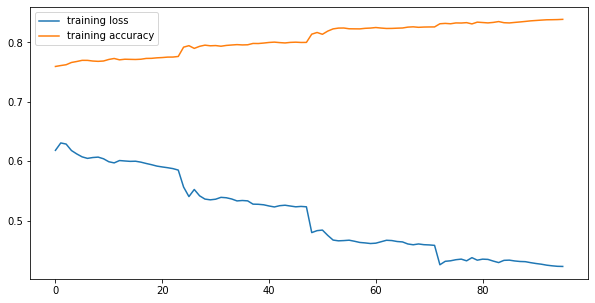

[0.6182030385732651, 0.6306434768438339, 0.6287856199344, 0.6178857358545065, 0.612125372171402, 0.607211103439331, 0.6046748892750059, 0.6061102546751499, 0.6068023171689775, 0.6040101101994515, 0.5989910866455598, 0.5970797220369181, 0.6010375794080588, 0.600300979741982, 0.5996573090950648, 0.5998885966464877, 0.5983288512510412, 0.5960794913437631, 0.5940375627969441, 0.5916909818947316, 0.5902506283067521, 0.5889840151505037, 0.5874529506978782, 0.5849860246106983, 0.5564512893557548, 0.5403745718300342, 0.5523140286405881, 0.5416488138586283, 0.5361646420359611, 0.5348975895345212, 0.5359512541549546, 0.5390848441049456, 0.5383929283420245, 0.536347426533699, 0.5330786583098498, 0.5337754641224941, 0.5331524763198999, 0.5276362964298044, 0.5274030213157336, 0.5265551010519266, 0.5245672623900807, 0.5229044178293811, 0.5250477630056833, 0.5258298797458411, 0.5244620984225046, 0.5231510196219791, 0.523822462208893, 0.5231719728186727, 0.47976187378168106, 0.48304235145449637, 0.483

In [ ]:
#Plotting the training loss.
#NOTE: As mentioned before due to timeout, the graph below shows from epoch 5 - 8

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.plot(total_loss_train, label = 'training loss')
ax.plot(total_acc_train, label = 'training accuracy')
plt.legend()
plt.show()

print(total_loss_train)
print(total_acc_train)

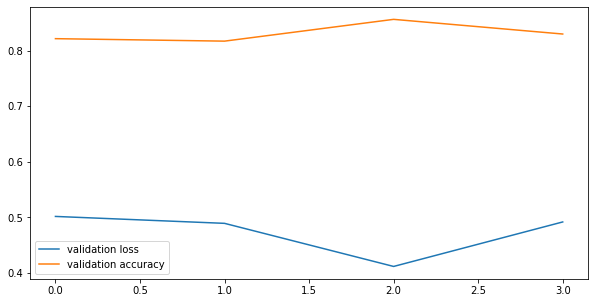

In [ ]:
#Plotting the validation loss.

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.plot(val_losses, label = 'validation loss')
ax.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
#Print validation loss and accuracy
print(val_acc)
print(val_losses)

[0.8215060763888888, 0.8170572916666666, 0.8562282986111112, 0.8298611111111112]
[0.5018672610167414, 0.4894200853887014, 0.41192602991941385, 0.4919322385103442]


In [ ]:
#CONFUSION MATRIX - function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
  

  
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    fig = plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#Loading the earlier trained model
model= torch.load('HAM_densenet_runv_final.pt')

In [ ]:
#Evaluating the model on validation data.

model.eval()
y_labels = []
y_predicted = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        batch, labels = data
        b_size = batch.size(0)
        batch = Variable(batch).to(device)
        outputs = model(batch)
        prediction = outputs.max(1, keepdim=True)[1]
        y_labels.extend(labels.cpu().numpy())
        y_predicted.extend(np.squeeze(prediction.cpu().numpy().T))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs.shape

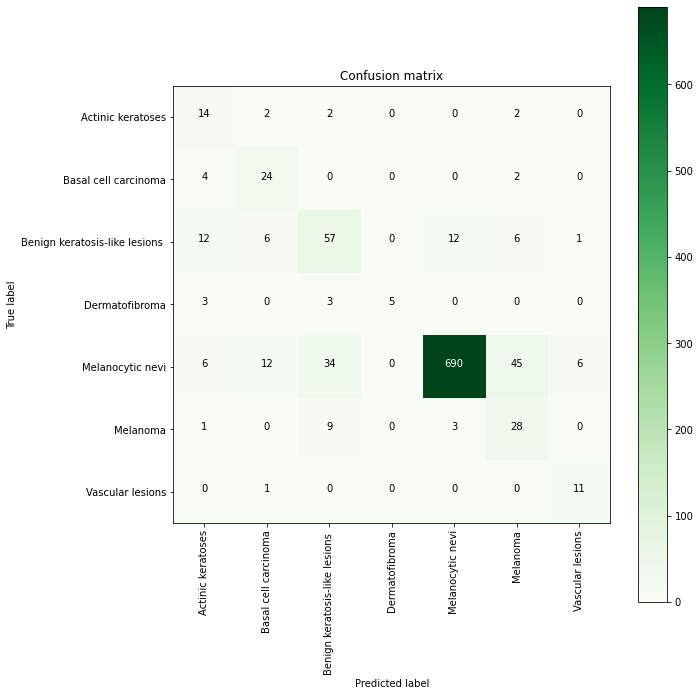

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_labels, y_predicted)
# plot the confusion matrix
plot_labels = [mapping[0], mapping[1], mapping[2], mapping[3], mapping[4], mapping[5],mapping[6]]
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
#CLASSIFICATION REPORT
report = classification_report(y_labels, y_predicted, target_names=plot_labels)
print(report)

                                precision    recall  f1-score   support

             Actinic keratoses       0.35      0.70      0.47        20
          Basal cell carcinoma       0.53      0.80      0.64        30
Benign keratosis-like lesions        0.54      0.61      0.57        94
                Dermatofibroma       1.00      0.45      0.62        11
              Melanocytic nevi       0.98      0.87      0.92       793
                      Melanoma       0.34      0.68      0.45        41
              Vascular lesions       0.61      0.92      0.73        12

                      accuracy                           0.83      1001
                     macro avg       0.62      0.72      0.63      1001
                  weighted avg       0.88      0.83      0.85      1001



**Insights:**


*   Class 4 - Dermatofibroma - has the highest f1 score.
*   The model attains 83% accuracy for classifying different types of skin cancer.
* However, the pitfalls of this model on OOD datasets are highlighted in the next section.



## Out-of-Distribution

In [ ]:
# For OOD - we test on in-distribution and out-of distribution data
# In-distribution: HAM10000 train dataloader and test dataloader
# OOD: For our midsem submission we use Clin-skin and BBox - both these datasets have been described earlier and in the report

In [ ]:
from natsort import natsorted


class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, img_loc


def OODdataset(data_type, batch_size, dataroot):
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4913, 0.4821, 0.4465], std=[0.2470, 0.2434, 0.2615])
    ])

    if data_type == 'imagenet_resize':
        dataset = CustomDataSet(os.path.join(dataroot,'imagenet/img'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)

    elif data_type == 'skin_cli':
        dataset = CustomDataSet(os.path.join(dataroot,'skin_cli/img'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)
        
    elif data_type == 'skin_derm':
        dataset = CustomDataSet(os.path.join(dataroot,'skins/dermoscopy/img'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)

    elif data_type == 'corrupted_bbox':
        dataset = CustomDataSet(os.path.join(dataroot,'corrupted/bbox/img'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)

    elif data_type == 'nct':
        dataset = CustomDataSet(os.path.join(dataroot,'nct/imgs'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)
          
    elif data_type == 'corrupted_bbox70':
        dataset = CustomDataSet(os.path.join(dataroot,'corrupted/bbox_70/img'), transform=trans)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)
        
    return test_loader

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
# We load our earlier trained model
model = torch.load("/content/drive/MyDrive/VOS/HAM_densenet_runv_final.pt")
device = torch.device('cuda:0')
model = model.to(device)

We implement a part of ODIN - "ENHANCING THE RELIABILITY OF
OUT-OF-DISTRIBUTION IMAGE DETECTION IN
NEURAL NETWORKS"

https://arxiv.org/pdf/1706.02690.pdf 

The method is based on an observation that a well-trained neural
network tends to assign higher softmax scores to in-distribution examples than out-of-distribution examples. Higher softmax scores indicates higher confidence of the model.

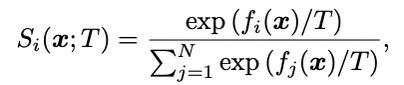

Assume that the neural network f = (f1, ..., fN ) is trained to classify N
classes. For each input x, the neural network assigns a label yˆ(x) = arg maxi Si(x; T) by computing
the softmax output for each class.

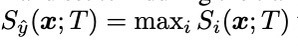


ODIN is a post-training OOD detection algorithm, whereas VOS sends supervisory signals during training.

If for any class S(x,T) is high, meaning the model has high-confidence in its prediction, this is not ideal for instances which are out of distribution.

Prior works have established the use of temperature scaling to distill the knowledge in neural networks and calibrate the prediction confidence in classification tasks.

An image x is classified as in-distribution if the softmax
score is greater than the threshold and vice versa. 

***In-distrubution : S_y(x,T) > Thresh
Out-of-distribution: S_y(x,T) <= Thresh***

In [ ]:
#Iterate through the dataloader, select the maximum softmax probability

def get_max_softmax(temper,loader,img_path=True):
        model.eval()
        y_label = []
        y_predict = []

        all_softouts = []
        all_imgloc = []
        all_preds = []
        with torch.no_grad():
            for i, data in enumerate(loader):
                if img_path:
                  images, imgloc = data
                N = images.size(0)
                images = Variable(images).to(device)
                outputs = model(images)
                prediction = outputs.max(1, keepdim=True)[1]
                outputs = outputs / temper
                soft_out = F.softmax(outputs, dim=1)
                #print(soft_out)
                soft_out, _ = torch.max(soft_out.data, dim=1)
                all_softouts.extend(np.array(soft_out.detach().cpu()))
                if img_path:
                  all_imgloc.extend(imgloc)
                all_preds.extend(prediction)

        if img_path:
          return all_softouts,all_imgloc,all_preds
        else:
          return all_softouts,all_preds

In [ ]:
# Loading earlier trained model
model = torch.load("/content/drive/MyDrive/VOS/HAM_densenet_runv_final.pt")
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
#Dataloader for corrupted_bbox
loader = OODdataset(data_type = 'corrupted_bbox',batch_size = 32, dataroot= '/content/drive/MyDrive/VOS/data')

In [ ]:
#temperature set to 1,100,1000 as per ODIN implementation

bbox_temp1 = get_max_softmax(1,loader) 
bbox_temp100 = get_max_softmax(100,loader)
bbox_temp1000 = get_max_softmax(1000,loader)

In [ ]:
#dataloader for clinical skin images
loader = OODdataset(data_type = 'skin_cli',batch_size = 32, dataroot= '/content/drive/MyDrive/VOS/data')

In [ ]:
#clinical skin images ,temperature set to 1,100,1000 as per ODIN implementation
cli_temp1 = get_max_softmax(1,loader)
cli_temp100 = get_max_softmax(100,loader)
cli_temp1000 = get_max_softmax(1000,loader)

In [ ]:
# To Evaluate OOD, we use the widely used metrics FPR95.

# FPR 95 denoted the FPR when the TPR of detection is 95%
# Here our task is to classify each image in OOD or ID
# As the In-Distribution dataset, we choose the validation dataloader (HAM 10000).
# BBox and Clin-Skin are OOD

In [ ]:
val_temp1 = get_max_softmax(1,val_loader)
val_temp100 = get_max_softmax(100,val_loader)
val_temp1000 = get_max_softmax(1000,val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#If softmax greater than the threshhold, then In-Distribution.
def get_tp_fp(max_softmax,is_ood,threshold):
    tp=0
    fp=0
    tn=0
    fn=0

    for i in range(len(max_softmax)):
      if max_softmax[i]>threshold and is_ood:
        fp += 1
      elif max_softmax[i] <= threshold and is_ood:
        tn += 1 
      elif max_softmax[i] <= threshold and is_ood==False:
        fn += 1
      elif max_softmax[i] > threshold and is_ood==False:
        tp += 1

    return tp,fp,tn,fn

In [ ]:
#Function to calculate the TPR-FPR, for ID and OOD classification
# WE SET THE TEMPERATURE HERE TO 1.

def get_tpr_fpr_temp1(thr):
  tp_val, fp_val,tn_val,fn_val = get_tp_fp(val_temp1[0],False,thr)
  tp_cli, fp_cli,tn_cli,fn_cli = get_tp_fp(cli_temp1[0],True,thr)
  tp_box, fp_box,tn_box,fn_box = get_tp_fp(bbox_temp1[0],True,thr)

  # TPR
  TPR = (tp_val+tp_cli+tp_box)/((tp_val+tp_cli+tp_box)+(tn_val+tn_cli+tn_box))
  #print(TPR)

  FPR = (fp_val+fp_cli+fp_box)/((fp_val+fp_cli+fp_box)+(tn_val+tn_cli+tn_box))
  #print(FPR)

  return TPR,FPR

In [ ]:
#To calculate the metric FPR95, i.e. FPR when TPR approx .95

all_tprs=[]
all_fprs=[]
for th in np.arange(0,1,0.1):
  tpr,fpr = get_tpr_fpr_temp1(th)
  all_tprs.append(tpr)
  all_fprs.append(fpr)
  if tpr >= 0.95:
    print(fpr)
  if tpr >= 0.95 and tpr<0.96:
    print("TPR95, FPR: {}, thresh:{}".format(fpr,th))

1.0
1.0
1.0
0.9994103773584906
0.9705188679245284
TPR95, FPR: 0.9705188679245284, thresh:0.4


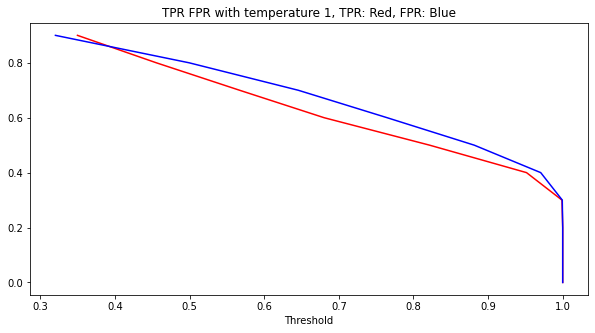

In [ ]:
fig = plt.figure(figsize=(10,5))

a = np.arange(0,1,0.1)
plt.plot(all_tprs,a,'r')
plt.plot(all_fprs,a,'b')
plt.xlabel('Threshold')
plt.title("TPR FPR with temperature 1, TPR: Red, FPR: Blue")
plt.show()

In [ ]:
# WE SET THE TEMPERATURE HERE TO 100

def get_tpr_fpr_temp100(thr):
  # For temperature 1

  tp_val, fp_val,tn_val,fn_val = get_tp_fp(val_temp100[0],False,thr)
  tp_cli, fp_cli,tn_cli,fn_cli = get_tp_fp(cli_temp100[0],True,thr)
  tp_box, fp_box,tn_box,fn_box = get_tp_fp(bbox_temp100[0],True,thr)

  # TPR
  TPR = (tp_val+tp_cli+tp_box)/((tp_val+tp_cli+tp_box)+(tn_val+tn_cli+tn_box))
  #print(TPR)

  FPR = (fp_val+fp_cli+fp_box)/((fp_val+fp_cli+fp_box)+(tn_val+tn_cli+tn_box))
  #print(FPR)

  return TPR,FPR

In [ ]:
all_tprs=[]
all_fprs=[]
for th in np.arange(0,1,0.1):
  tpr,fpr = get_tpr_fpr_temp100(th)
  all_tprs.append(tpr)
  all_fprs.append(fpr)
  if tpr >= 0.95:
    print("TPR>95, FPR: {}".format(fpr))
  if tpr >= 0.95 and tpr<0.96:
    print("TPR95, FPR: {}".format(fpr))

TPR>95, FPR: 1.0
TPR>95, FPR: 1.0


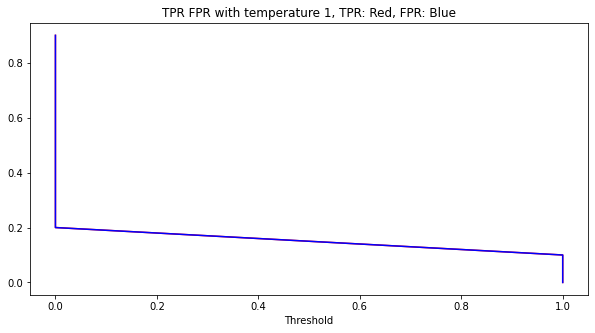

In [ ]:
fig = plt.figure(figsize=(10,5))

a = np.arange(0,1,0.1)
plt.plot(all_tprs,a,'r')
plt.plot(all_fprs,a,'b')
plt.title("TPR FPR with temperature 1, TPR: Red, FPR: Blue")
plt.xlabel('Threshold')
plt.show()

In [ ]:
val_temp100[0][0:20]

[0.15862772,
 0.14871769,
 0.15457985,
 0.15180203,
 0.1540428,
 0.15218768,
 0.15233693,
 0.15765864,
 0.15129526,
 0.153851,
 0.15009153,
 0.15175058,
 0.15093184,
 0.1496378,
 0.15540911,
 0.15136255,
 0.15119767,
 0.14883286,
 0.1501958,
 0.15157254]

**Inference:** 

* At higher temperature, the model is not able to identify In-Distribution data with good accuracy as seen in the above values, all classes tend to get similar probability ( Range 0.14-0.15 -> 0.14 x 7Classes ~ 1 (total prob))

* The FPR95 score using the above method is very high (lower FPR95, better OOD detection model). We aim to use VOS in the latter part to improve upon this.

In [ ]:
# For qualitative analysis, we find out instances of image that got classified as ID
# For temperature1, thereshold is 0.4

In [ ]:
#saving image path that was misclassified as In-Distribution.

img_paths = []
labels=[]
for i in range(len(cli_temp1[0])):
  if(cli_temp1[0][i])>= 0.4:
    # misclassified as ID
    img_paths.append(cli_temp1[1][i])
    labels.append(cli_temp1[2][i])

In [ ]:
print(img_paths[0])
print(img_paths[-1])

/content/drive/MyDrive/VOS/data/skin_cli/img/red_00119_00.jpeg
/content/drive/MyDrive/VOS/data/skin_cli/img/tile_93588_22.jpeg


In [ ]:
print(labels[0])
print(labels[-1])

tensor([2], device='cuda:0')
tensor([4], device='cuda:0')


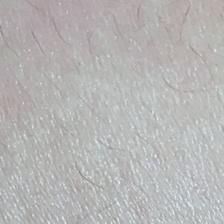

OOD Image, misclassified as Benign keratosis-like lesions 


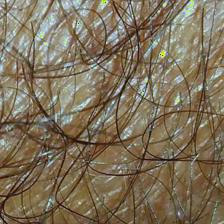

OOD Image, misclassified as Melanocytic nevi


In [ ]:
#for cli-skin dataset

from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/VOS/data/skin_cli/img/red_00119_00.jpeg')
cv2_imshow(img)
print("OOD Image, misclassified as {}".format(mapping[2]))
img = cv2.imread('/content/drive/MyDrive/VOS/data/skin_cli/img/tile_93588_22.jpeg')
cv2_imshow(img)
print("OOD Image, misclassified as {}".format(mapping[4]))

In [ ]:
img_paths = []
labels=[]
for i in range(len(bbox_temp1[0])):
  if(bbox_temp1[0][i])>= 0.4:
    # misclassified as ID
    img_paths.append(bbox_temp1[1][i])
    labels.append(bbox_temp1[2][i])

In [ ]:
print(img_paths[0])
print(img_paths[-1])

/content/drive/MyDrive/VOS/data/corrupted/bbox/img/ISIC_0000008.png
/content/drive/MyDrive/VOS/data/corrupted/bbox/img/ISIC_0072898.png


In [ ]:
print(labels[0])
print(labels[-1])

tensor([4], device='cuda:0')
tensor([4], device='cuda:0')


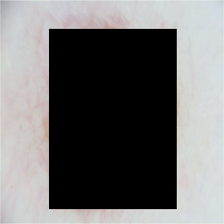

OOD Image, misclassified as Melanocytic nevi


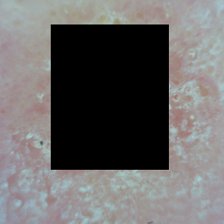

OOD Image, misclassified as Melanocytic nevi


In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/VOS/data/corrupted/bbox/img/ISIC_0000008.png')
cv2_imshow(img)
print("OOD Image, misclassified as {}".format(mapping[4]))
img = cv2.imread('/content/drive/MyDrive/VOS/data/corrupted/bbox/img/ISIC_0072898.png')
cv2_imshow(img)
print("OOD Image, misclassified as {}".format(mapping[4]))

**INFERENCES:**


*   The images shown above were misclassified since they were not recognised to be OOD. These errors are critical in the medical domain and hence OOD detection is pivotal.
*   These are rather difficult images for OOD as they match quite closely to the in-distribution data
